## New Section

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
53.90107178688049


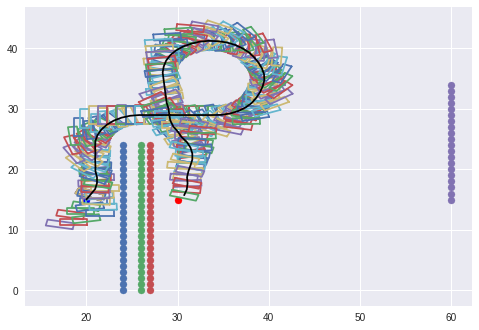

In [26]:
# -*- coding: utf-8 -*-

############PROGRAM STARTS HERE ######################
import numpy as np
import math as MT
from math import floor
import matplotlib.pyplot as plt
import time
import math

###CONSTANTS
max_angle = 0.785398 #45Deg
min_angle = -0.785398 #-45Deg
free_space=0
locked_space=1.0

### HYPER PARAMETERS
NUMBERS_OF_STEERS = 4
STEER_OFFSET = 5.0*np.pi/180
LENGTH = 0.8
NUM_THETA_CELLS = 60
RADIUS_OF_WHEEL= 0.05

### GRID MAKING
grid_x_m = 40
grid_y_m = 40

### FOR CELL DIVISION
coll_cell_side = 0.5
grid_on_x = np.int( np.ceil(grid_x_m/coll_cell_side) )
grid_on_y = np.int( np.ceil(grid_y_m/coll_cell_side) )

### FIT ZEROS
GRID_TEST = np.zeros((grid_on_x,grid_on_y),np.int)

### INITIALIZE COST_MAPS AND ASTAR CLOSE MAPS
value_map = np.array([[1000 for x in range(grid_on_x)] for y in range(grid_on_y)])

### MOTION MATRIX FOR ASTAR
motion_mat=np.array([[1,0],[-1,0],[0,-1],[0,1]])

### STATE CLASS
class state:
  def __init__(self,x,y,theta,g,f,h,steer,w,x1,y1,theta1,x2=0,y2=0,theta2=0,x3=0,y3=0,theta3=0,x4=0,y4=0,theta4=0,d1=2):
    self.x=x
    self.y=y
    self.theta=theta
    self.g=g
    self.f=f
    self.h=h
    self.steer=steer
    self.w=w
    
    self.d1=d1
    
    self.x1=x1
    self.y1=y1
    self.theta1=theta
    
    self.x2=x1-d1*math.cos(theta1)
    self.y2=y1-d1*math.sin(theta1)
    self.theta2=theta
    
    self.x3=x2-d1*math.cos(theta2)
    self.y3=y2-d1*math.sin(theta2)
    self.theta3=theta
    
    self.x4=x3-d1*math.cos(theta3)
    self.y4=y3-d1*math.sin(theta3)
    self.theta4=theta
    

 ## GOAL NODE
class goal:
    def __init__(self, x, y):
        self.x = x
        self.y = y

### INPUT VEHICLE CO-ORDINATES
class vehicle_points():
  def __init__(self,input_co_ordinates,center):
    self.input_co_ordinates=input_co_ordinates
    self.center=center

### PATH CLASS FOR TRACKING
class path():
  def __init__(self,closed,came_from,final):
    self.closed=closed
    self.came_from=came_from
    self.final=final


### AUGMENT DELTA +/- GIVEN OFFSET
def delta_augmentation(delta, numbers, offset):
    delta_list = []
    delta_list.append(delta)
    delta_calc_add=delta_calc_sub = delta
    for i in range(0 ,numbers):
        delta_calc_add += offset
        delta_calc_sub -= offset
        if delta_calc_add < max_angle:
            delta_list.append(delta_calc_add)
        if delta_calc_sub > min_angle:
            delta_list.append(delta_calc_sub)
    return delta_list

### Angular velocity augmentation
def angular_velocity_augmentation(delta,numbers, offset,high,low):
    delta_list = []
    delta_list.append(delta)
    delta_calc_add=delta_calc_sub = delta
    for i in range(0 ,numbers):
        delta_calc_add += offset
        delta_calc_sub -= offset
        if delta_calc_add < high:
            delta_list.append(delta_calc_add)
        if delta_calc_sub > low:
            delta_list.append(delta_calc_sub)
    return delta_list

### NEW STATE TRANSITIONS
def new_state_transition(current_state,goal,speed):
    next_states = []
    velocity_list = angular_velocity_augmentation(0, 10,np.deg2rad(5),np.deg2rad(40),np.deg2rad(-40))
    #delta_angles = delta_augmentation( delta=current_state.steer, numbers=NUMBERS_OF_STEERS,offset=STEER_OFFSET)
    DT=1.0/speed
    for delta in velocity_list:
        VR=(2*speed + delta*LENGTH)/2*RADIUS_OF_WHEEL
        VL=(2*speed - delta*LENGTH)/2*RADIUS_OF_WHEEL
        #omega=RADIUS_OF_WHEEL/LENGTH*(VR-VL)
        theta = normalize_theta(current_state.theta + (delta * DT))
        dX = speed * np.cos(theta) * DT
        dY = speed * np.sin(theta) * DT
        #print(dX,dY)
        
        
        x    = current_state.x + dX
        y    = current_state.y + dY
        g2     = current_state.g + np.sqrt(dX*dX + dY*dY)
        
        
       
        #Trolley1
        t1=current_state.theta1+speed/current_state.d1 * math.sin(theta-current_state.theta1)
        x1=x -current_state.d1*math.cos(t1)
        y1=y-current_state.d1*math.sin(t1)
        
        
        #Trolley2 
        t2=current_state.theta2 + speed/current_state.d1 *math.cos(current_state.theta-current_state.theta1)* math.sin(current_state.theta1-current_state.theta2)
        x2=x1 -current_state.d1*math.cos(t2)
        y2=y1-current_state.d1*math.sin(t2)
        

        
        #Trolley3
        t3=current_state.theta3 + speed/current_state.d1 *(math.cos(current_state.theta-current_state.theta1) + math.cos(current_state.theta1-current_state.theta2))* math.sin(current_state.theta1-current_state.theta2)
        x3=x2 -current_state.d1*math.cos(t3)
        y3=y2-current_state.d1*math.sin(t3)
        
        
        #Trolley4
        t4=current_state.theta4 + speed/current_state.d1 *(math.cos(current_state.theta2-current_state.theta3) + math.cos(current_state.theta-current_state.theta1) + math.cos(current_state.theta1-current_state.theta2))* math.sin(current_state.theta1-current_state.theta2)
        x4=x3 -current_state.d1*math.cos(t4)
        y4=y3-current_state.d1*math.sin(t4)
        
        
        arc_cost=arc_heuristic(goal.x-x,goal.y-y,theta)
        startpoint = [current_state.x,current_state.y]
        endpoint = [goal.x, goal.y]
        h2=value_map[idx(x)][idx(y)]+arc_cost
        f2     = g2 + h2
        new_state=state(x,y,theta,g2,f2,h2,delta,delta,x1,y1,t1,x2,y2,t2,x3,y3,t3,x4,y4,t4)
        next_states.append(new_state)
    return next_states

### TRANSFORM VEHICLE CO-ORDINATES
def transform_vehicle_co_ordinates(vehicle_point_object, next_state, angle_of_rotation):
    displaced_matrix = np.array([next_state[0]-vehicle_point_object.center[0],next_state[1]-vehicle_point_object.center[1]])
    transformed_matrix=np.add(vehicle_point_object.input_co_ordinates,displaced_matrix)
    return vehicle_points(rotate_vehicle_co_ordinates(vehicle_points(transformed_matrix,next_state),angle_of_rotation),next_state)


### ROTATE VEHICLE CO-ORDINATES
def rotate_vehicle_co_ordinates(vehicle_point_object,angle_of_rotation):
    rotation_matrix = np.array([[np.cos(angle_of_rotation), np.sin(angle_of_rotation)],
                                [-np.sin(angle_of_rotation), np.cos(angle_of_rotation)]])
    return np.add(vehicle_point_object.center,np.matmul(np.subtract(vehicle_point_object.input_co_ordinates,vehicle_point_object.center), rotation_matrix))


### CHECK VEHICLE IN SAFE POSITION
def is_vehicle_in_safe_position(vehicle_point_object,grid):
  for point in vehicle_point_object.input_co_ordinates:
    if(is_within_grid( idx(point[0]),idx(point[1])) and
       (grid[idx(point[0])][idx(point[1])]==0)):
      continue
    else:
      return False
  return True

### CHK A STAR VEHICLE:
def A_vehicle_is_safe(vehicle_point_A,add_value,grid):
  vp=vehicle_point_A.input_co_ordinates+add_value
  for point in vp:
    if(is_within_grid( idx(point[0]),idx(point[1])) and
       (grid[idx(point[0])][idx(point[1])]==0)):
      continue
    else:
      return False
  return True



### EUCLIDEAN DISTANCE
def euclidean_distance(start_point,end_point):
  return np.round(np.sqrt((end_point[0]-start_point[0])**2 +(end_point[1]-start_point[1])**2),4)

### ARC HEURISTIC
def arc_heuristic(x,y,theta_to_be_taken):
  ang_rad=normalize_theta(np.arctan2(y,x))
  diff=np.pi-abs(abs(theta_to_be_taken-ang_rad)-np.pi)
  return diff

### NORMALIZE THETA
def normalize_theta(theta):
  if( theta<0 ):
    theta +=( 2*np.pi )
  elif( theta>2*np.pi ):
    theta %=( 2*np.pi)
  return theta

### THETA TO STACK NUMBER
def theta_to_stack_number(theta):
  new = (theta+2*np.pi)%(2*np.pi)
  stack_number = round(new*NUM_THETA_CELLS/2*np.pi)%NUM_THETA_CELLS
  return int(stack_number)

### FLOOR VALUE
def idx(value):
  return int(MT.floor(value))

### CHECK WITHIN GRID
def is_within_grid(x,y):
  return (x>=0 and x<grid_on_x and y>=0 and y<grid_on_y)

### IS_GOAL_REACHED
def is_goal_reached(start,goal):
  result=False
  if( idx(start[0]) == idx(goal[0]) and idx(start[1])==idx(goal[1])):
    result=True
  return result

### BUILDS THE COST MAP - Here the current state is the goal
def build_cost_map(current_state,goal,grid):
  expand_grid = [[' ' for x in range(grid_on_x)] for y in range(grid_on_y)]
  expand_grid[current_state.x][current_state.y]='*'
  open_list = []
  is_goal_attained=False
  open_list.append(current_state)
  #IMPORTANT
  value_map[current_state.x][current_state.y]=0
  while(len(open_list)>0):
    old_state=open_list.pop(0)
    node=np.array([old_state.x,old_state.y])
    if(goal.x==old_state.x and goal.y==old_state.y):
      is_goal_attained=True
      print("GOAL IS REACHABLE!")

    for move in motion_mat:
      nxt_node=node+move
      if( is_within_grid(nxt_node[0],nxt_node[1])):
        if(grid[nxt_node[0]][nxt_node[1]]==0 and expand_grid[nxt_node[0]][nxt_node[1]]!='*'):
          if(A_vehicle_is_safe(vehicle_point_A,np.array([nxt_node]),grid)):
            g2=old_state.g+1
            new_state=state(nxt_node[0],nxt_node[1],0,g2,0,0,0,0,0,0,0)
            open_list.append(new_state)
            expand_grid[nxt_node[0]][nxt_node[1]]='*'
            value_map[nxt_node[0]][nxt_node[1]]=g2
  return is_goal_attained


### SEARCH ALGORITHM
def Hybrid_A_Star(grid,current_state,goal,vehicle_point_object,speed):
  print("STARTED HYBRID A*")
  start_time = time.time()
  closed = np.array([[[free_space for x in range(grid_on_x)] for y in range(grid_on_y)] for cell in range(NUM_THETA_CELLS)])
  came_from = [[[free_space for x in range(grid_on_x)] for y in range(grid_on_y)] for cell in range(NUM_THETA_CELLS)]
  is_goal_attained=False
  stack_number=theta_to_stack_number(current_state.theta)
  closed[stack_number][idx(current_state.x)][idx(current_state.y)]=1
  came_from[stack_number][idx(current_state.x)][idx(current_state.y)]=current_state
  total_closed=1
  opened=[current_state]

  while (len(opened)>0):
    #print('1')
    opened.sort(key=lambda state_srt : float(state_srt.f))
    state_now=opened.pop(0)
    #print([state_now.x,state_now.y,state_now.theta*np.pi/180])
    if(is_goal_reached([idx(state_now.x),idx(state_now.y)],[idx(goal.x),idx(goal.y)])):
      is_goal_attained=True
      print('GOAL REACHED BY HYBRID A*')
      ret_path=path(closed,came_from,state_now)
      end_time = time.time()
      print(end_time - start_time)
      return (is_goal_attained,ret_path)

    for evry_state in new_state_transition(state_now,goal,speed):
      if(abs(current_state.theta4-evry_state.theta4)<5):
      
        #print('Before',[evry_state.x,evry_state.y,evry_state.theta*np.pi/180])
        if(not is_within_grid(idx(evry_state.x),idx(evry_state.y))):
          continue
        #print('im here')
        stack_num=theta_to_stack_number(evry_state.theta)
        #print([stack_num,idx(evry_state.x),idx(evry_state.y)])
        if closed[stack_num][idx(evry_state.x)][idx(evry_state.y)]==0 and grid[idx(evry_state.x)][idx(evry_state.y)]==0:
          new_vehicle_point_obj = transform_vehicle_co_ordinates(vehicle_point_object,[evry_state.x,evry_state.y],evry_state.theta)
          new_vehicle_point_obj_trolley1 = transform_vehicle_co_ordinates(vehicle_point_object,[evry_state.x1,evry_state.y1],evry_state.theta1)
          new_vehicle_point_obj_trolley2 = transform_vehicle_co_ordinates(vehicle_point_object,[evry_state.x2,evry_state.y2],evry_state.theta2)
          new_vehicle_point_obj_trolley3 = transform_vehicle_co_ordinates(vehicle_point_object,[evry_state.x3,evry_state.y3],evry_state.theta3)
          new_vehicle_point_obj_trolley4 = transform_vehicle_co_ordinates(vehicle_point_object,[evry_state.x4,evry_state.y4],evry_state.theta4)


          list_=np.concatenate((new_vehicle_point_obj.input_co_ordinates,new_vehicle_point_obj_trolley1.input_co_ordinates,new_vehicle_point_obj_trolley2.input_co_ordinates,new_vehicle_point_obj_trolley3.input_co_ordinates,new_vehicle_point_obj_trolley4.input_co_ordinates),axis=0) 

          t1=is_vehicle_in_safe_position(new_vehicle_point_obj_trolley1,grid)
          t2=is_vehicle_in_safe_position(new_vehicle_point_obj_trolley2,grid)
          t3=is_vehicle_in_safe_position(new_vehicle_point_obj_trolley3,grid)
          t4=is_vehicle_in_safe_position(new_vehicle_point_obj_trolley4,grid)
          #print("AGV",new_vehicle_point_obj.center[0],new_vehicle_point_obj.center[1])
          #print("Trolley1",new_vehicle_point_obj_trolley1.center[0],new_vehicle_point_obj_trolley1.center[1])
          #print("Trolley4",new_vehicle_point_obj_trolley4.center[0],new_vehicle_point_obj_trolley4.center[1])


          if(is_vehicle_in_safe_position(new_vehicle_point_obj,grid) and t1 and t2 and t3 and t4):
            if is_self_collision_avoided(list_):
              opened.append(evry_state)
              closed[stack_num][idx(evry_state.x)][idx(evry_state.y)]=1
              came_from[stack_num][idx(evry_state.x)][idx(evry_state.y)]=state_now
              total_closed+= 1
              #print("x,y,theta  of AGV",evry_state.x,evry_state.y,evry_state.theta)
              #print("x,y,theta  of trolley",evry_state.x1,evry_state.y1,evry_state.theta1)

  print('No Valid path')
  ret_path=path(closed,came_from,evry_state)
  return (is_goal_attained,ret_path) 



def is_self_collision_avoided(list_):
    list1_=np.unique(list_,axis=0)
    if(list1_.shape[0]==list_.shape[0]):
        return True
    else:
        return False 



### RECONSTRUCT PATH
def reconstruct_path(came_from, start, final):
    path                 = [(final)]
    stack                = theta_to_stack_number(final.theta)
    current              = came_from[stack][idx(final.x)][idx(final.y)]
    stack                = theta_to_stack_number(current.theta)
    while [idx(current.x), idx(current.y)] != [idx(start[0]), idx(start[1])] :
        path.append(current)
        current              = came_from[stack][idx(current.x)][idx(current.y)]
        stack                = theta_to_stack_number(current.theta)
    return path


###DISPLAY PATH
def show_path(path, start, goal,vehicle_pt_obj_act,trolley_pt_obj_act):
  X=[start[0]]
  Y=[start[1]]
  X_t = [start[0]]
  Y_t = [start[1]]
  X_t2 = [start[0]]
  Y_t2 = [start[1]]
  X_t3 = [start[0]]
  Y_t3 = [start[1]]
  X_t4 = [start[0]]
  Y_t4 = [start[1]]
  Theta,Theta_t1,Theta_t2,Theta_t3,Theta_t4=[],[],[],[],[]
  path.reverse()
  X     += [p.x for p in path]
  Y     += [p.y for p in path]
  Theta+=[p.theta for p in path]
  X_t     += [p.x1 for p in path]
  Y_t     += [p.y1 for p in path]
  Theta_t1+=[p.theta1 for p in path]
  
  X_t2     += [p.x2 for p in path]
  Y_t2     += [p.y2 for p in path]
  Theta_t2+=[p.theta2 for p in path]
  
  X_t3     += [p.x3 for p in path]
  Y_t3    += [p.y3 for p in path]
  Theta_t3+=[p.theta3 for p in path]
  
  X_t4     += [p.x4 for p in path]
  Y_t4     += [p.y4 for p in path]
  Theta_t4+=[p.theta4 for p in path]
  
  for i in range(len(X)-1):
    Xj=[]
    Yj=[]
    Xj_t=[]
    Yj_t=[]
    
    Xj_t2=[]
    Yj_t2=[]
    Xj_t3=[]
    Yj_t3=[]
    Xj_t4=[]
    Yj_t4=[]
    
    vehicle_pt_obj_now=transform_vehicle_co_ordinates(vehicle_pt_obj_act,[X[i],Y[i]], Theta[i])
    trolley_pt_obj_now1=transform_vehicle_co_ordinates(trolley_pt_obj_act,[X_t[i],Y_t[i]], Theta_t1[i])
    
    trolley_pt_obj_now2=transform_vehicle_co_ordinates(trolley_pt_obj_act,[X_t2[i],Y_t2[i]], Theta_t2[i])
    trolley_pt_obj_now3=transform_vehicle_co_ordinates(trolley_pt_obj_act,[X_t3[i],Y_t3[i]], Theta_t3[i])
    trolley_pt_obj_now4=transform_vehicle_co_ordinates(trolley_pt_obj_act,[X_t4[i],Y_t4[i]], Theta_t4[i])
    
    rev = vehicle_pt_obj_now.input_co_ordinates
    rev_t = trolley_pt_obj_now1.input_co_ordinates
    rev_t2 = trolley_pt_obj_now2.input_co_ordinates
    rev_t3 = trolley_pt_obj_now3.input_co_ordinates
    rev_t4 = trolley_pt_obj_now4.input_co_ordinates
    
    revI=rev[:4]
    revL=rev[4:]
    
    revI_t = rev_t[:4]
    revL_t = rev_t[4:]
    
    revI_t2 = rev_t2[:4]
    revL_t2 = rev_t2[4:]
    
    revI_t3 = rev_t3[:4]
    revL_t3 = rev_t3[4:]
    
    revI_t4 = rev_t4[:4]
    revL_t4 = rev_t4[4:]
    
    revF=np.concatenate([revI,revL[::-1]])
    revF_t = np.concatenate([revI_t,revL_t[::-1]])
    revF_t2 = np.concatenate([revI_t2,revL_t2[::-1]])
    revF_t3 = np.concatenate([revI_t3,revL_t3[::-1]])
    revF_t4 = np.concatenate([revI_t4,revL_t4[::-1]])
    
    
    l=np.append(revF,[revF[0]],axis=0)
    l_t=np.append(revF_t,[revF_t[0]],axis=0)
    l_t2=np.append(revF_t2,[revF_t2[0]],axis=0)
    l_t3=np.append(revF_t3,[revF_t3[0]],axis=0)
    l_t4=np.append(revF_t4,[revF_t4[0]],axis=0)
    
    for i,j,k,l,m in zip(l,l_t,l_t2,l_t3,l_t4):
      Xj.append(i[0])
      Yj.append(i[1])
      Xj_t.append(j[0])
      Yj_t.append(j[1])
      
      Xj_t2.append(k[0])
      Yj_t2.append(k[1])
      Xj_t3.append(l[0])
      Yj_t3.append(l[1])
      Xj_t4.append(m[0])
      Yj_t4.append(m[1])
      
    plt.plot(Xj,Yj)
    plt.plot(Xj_t,Yj_t)
    plt.plot(Xj_t2,Yj_t2)
    plt.plot(Xj_t3,Yj_t3)
    plt.plot(Xj_t4,Yj_t4)
    ##################################################
  
   
  #print([np.round(p.steer*180/np.pi,2) for p in path])
  plt.plot(X,Y, color='black')
  #plt.plot(X_t,Y_t, color='blue')
  plt.scatter([start[0]], [start[1]], color='blue')
  plt.scatter([goal[0]], [goal[1]], color='red')
  plt.show()

### PUT OBSTACLES:
def put_obstacles(X_list,Y_list,grid):
  if(len(X_list)>0):
    for i in  X_list:
      x_XO=[]
      x_YO=[]
      for k in range(i[1],i[2]):
        x_XO.append(i[0])
        x_YO.append(k)
        grid[i[0]][k]=1
      plt.scatter(x_XO,x_YO)
  if(len(Y_list)>0):
    for i in Y_list:
      y_XO=[]
      y_YO=[]
      for k in range(i[1],i[2]):
        y_XO.append(i[0])
        y_YO.append(k)
        grid[k][i[0]]=1
      plt.scatter(y_YO,y_XO)

### PUT OBSTACLES:
def put_obstacles(X_list,Y_list,grid):
  if(len(X_list)>0):
    for i in  X_list:
      x_XO=[]
      x_YO=[]
      for k in range(i[1],i[2]):
        x_XO.append(i[0])
        x_YO.append(k)
        grid[i[0]][k]=1
      plt.scatter(x_XO,x_YO)
  if(len(Y_list)>0):
    for i in Y_list:
      y_XO=[]
      y_YO=[]
      for k in range(i[1],i[2]):
        y_XO.append(i[0])
        y_YO.append(k)
        grid[k][i[0]]=1
      plt.scatter(y_YO,y_XO)

def search(start,goal_node,present_heading,grid,speed):
  
  vehicle_pt_obj=transform_vehicle_co_ordinates(vehicle_pt_obj_actual,start,present_heading)
  x1=vehicle_pt_obj.center[0]-2*math.cos(present_heading)
  y1=vehicle_pt_obj.center[1]-2*math.sin(present_heading)
  theta1=present_heading
  current_state = state(vehicle_pt_obj.center[0], vehicle_pt_obj.center[1], present_heading, 0.0, 0.0, 0.0,0.0,0.0,x1,y1,theta1)
  if(build_cost_map(state(goal_node.x,goal_node.y,0,0,0,0,0,0,x1,y1,theta1),goal(start[0],start[1]),grid)):
    process_further,ret_val=Hybrid_A_Star(GRID_TEST,current_state,goal_node,vehicle_pt_obj,speed)
    if(process_further):
      show_path(reconstruct_path(ret_val.came_from,start,ret_val.final),start,[goal_node.x,goal_node.y],vehicle_pt_obj_actual,trolley_pt_obj_actual)
      
    else:
      print("GOAL CANT BE REACHED!!")
  else:
    print("GOAL CANT BE REACHED!!")

put_obstacles([[24,0,25],[26,0,25],[27,0,25],[60,15,35]],[],GRID_TEST)
### A STAR VEHICLE POINTS
vehicle_point_A=vehicle_points(np.array([[0,3],[0,2],[0,1],[0,-1],[0,-2],[0,-3],[1,0],[2,0],[3,0],[-1,0],[-2,0],[-3,0]]),[0,0])
### HYBRID VEHICLE POINTS
vehicle_pt_obj_actual = vehicle_points( np.array([[0.5,0.5],[0.5,1.5],[0.5,2.5],[0.5,3.5],[1.5,0.5],[1.5,1.5],[1.5,2.5],[1.5,3.5]]),[0,2] )
trolley_pt_obj_actual = vehicle_points( np.array([[0.5,0.5],[0.5,1.5],[0.5,2.5],[0.5,3.5],[1.5,0.5],[1.5,1.5],[1.5,2.5],[1.5,3.5]]),[0,2] )
#trolley_pt_obj_actual = vehicle_points(np.array([[-1,1],[-1,1.5],[-1,2],[-1,2.5],[-2,1],[-2,1.5],[-2,2],[-2,2.5]]),[0,2])
## CALL SEARCH
search([20,15],goal(30,15),(np.pi/4),GRID_TEST,3)